In [15]:
# Math libraries
import numpy as np
# Image support
import skimage as ski
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity
from skimage.metrics import mean_squared_error as mse
# DICOM support
# import pydicom
# from pydicom.dataset import Dataset, FileDataset
# import pydicom._storage_sopclass_uids
# For filtering
import cv2
# Jupyter widgets
from ipywidgets import interact, IntSlider, Text, Button, VBox
# To be aware of the environment
import datetime

In [16]:
def loadImage(filename):
    image = ski.io.imread(filename)
    image = image.astype(np.float64)
    if len(image.shape) == 3:
        image = ski.color.rgb2gray(image)
    image /= np.max(image)
    return image

def saveImage(image, filename):
    data = (image * 255).astype(np.uint8)
    ski.io.imsave(filename, data)

def showImage(image, title=None):
    if title is not None:
        plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.show()

In [17]:
def radonTransform(image, detectors = 180, scans = 180, detectingAngle = 180):
	center = np.array(image.shape) // 2     # Center of the emitter-detector system
	radius = np.sqrt(2) * max(center)       # Radius of the round frame (half-diagonal of the image)
	radonImage = np.zeros((scans, detectors), dtype=image.dtype)
	phi = np.deg2rad(detectingAngle)        # Span of the detectors arc
	
	# Where to place the emitter in subsequent scans
	scanAngles = np.linspace(0, 2 * np.pi, scans, endpoint=False)

	detectorAngleGap = phi / (detectors - 1)
	for i, angle in enumerate(scanAngles):
		
		E = np.array([np.cos(angle), np.sin(angle)]) * radius + center
		
		for j in range(detectors):
			detectorAngle = angle + np.pi - phi / 2 + j * detectorAngleGap
			D = np.array([np.cos(detectorAngle), np.sin(detectorAngle)]) * radius + center

			
			y, x = ski.draw.line_nd(E, D)
			# print("x:")
			# print(len(x))
			# print("y")
			# print(len(y))

			inBounds = (0 <= x) & (x < image.shape[1]) & (0 <= y) & (y < image.shape[0])

			# print("INBOUNDS")
			# print(inBounds)
			# print(len(inBounds))
			

			line = (y[inBounds], x[inBounds])


			# print("LINE:")
			# print(line)
			# print("X")
			# print("x[0]",x[0])
			# print("x[1]",x[1])
			# print("x[2]",x[2])
			# print("Y")
			# print("y[0]",y[0])
			# print("y[1]",y[1])
			# print("y[2]",y[2])

			# line_x = []
			# line_y = []
			# for i in range(len(x)):
			# 	if (0 <= x[i]) and (x[i] < image.shape[1]) and (0 <= y[i]) and (y[i] < image.shape[0]):
			# 		line_x.append(x[i])
			# 		line_y.append(y[i])

			# print("len linex",len(line_x))
			# print("len linex",len(line_y))
			# print("len line",len(line[0]))
			# print("len line",len(line[1]))

			# linex = np.array(line_x)
			# liney = np.array(line_y)

			# line2 = (liney, linex)

			# print("line2")
			# print(line2)


			
			
			# Average the values of the image along the line
			radonImage[i, j] = np.average(image[line] if len(line[0]) > 0 else [0])

			# if len(line2[0]) > 0:
			# 	radonImage[i, j] = np.average(image[line2])
			# else:
			# 	radonImage[i, j] = [0]


	return radonImage

In [18]:
invRadonSteps = [] 							# invRadonSteps - list of step-by step images
def inverseRadonTransform(image, shape, detectingAngle = 180):
    global invRadonSteps
    scans = image.shape[0]
    detectors = image.shape[1]
    center = np.array(shape) // 2     		# Center of the emitter-detector system
    radius = np.sqrt(2) * max(center)       # Radius of the round frame (half-diagonal of the image)
    invRadonImage = np.zeros(shape, dtype=image.dtype)
    phi = np.deg2rad(detectingAngle)        # Span of the detectors arc
    invRadonSteps = []

    # Where to place the emitter in subsequent scans
    scanAngles = np.linspace(0, 2 * np.pi, scans, endpoint=False)
    detectorAngleGap = phi / (detectors - 1)
    for i, angle in enumerate(scanAngles):
        E = np.array([np.cos(angle), np.sin(angle)]) * radius + center

        for j in range(detectors):
            # Where to place the j-th detector
            detectorAngle = angle + np.pi - phi / 2 + j * detectorAngleGap
            D = np.array([np.cos(detectorAngle), np.sin(detectorAngle)]) * radius + center

            # Make a line between the emitter and the detector
            # And ensure it is in bounds of the image
            y, x = ski.draw.line_nd(E, D)
            inBounds = (0 <= x) & (x < shape[1]) & (0 <= y) & (y < shape[0])
            line = (y[inBounds], x[inBounds])

            # Average the values of the image along the line
            invRadonImage[line] += image[i, j]
        invRadonSteps.append(invRadonImage.copy())
    return invRadonImage


def normalizePostTransform(image):
    image = np.maximum(image, 0)
    image = (image / np.quantile(image, 0.999)).astype(np.float64)
    image = np.minimum(image, 1)
    return image

In [19]:
scans = 180
detectors = 180
detectingAngle = 180
imageName = 'xd.jpg'

def setParams(numScans, numDetectors, detectingArchAngle, inputFileName):
    global scans, detectors, detectingAngle, imageName
    scans = numScans
    detectors = numDetectors
    detectingAngle = detectingArchAngle
    imageName = inputFileName

interact(setParams,
    numScans=IntSlider(min=90, max=720, step=90, value=180, description='Scans'),
    numDetectors=IntSlider(min=90, max=720, step=90, value=180, description='Detectors'),
    detectingArchAngle=IntSlider(min=45, max=270, step=45, value=180, description='Det. angle'),
    inputFileName=Text(value='xd.jpg', description='Input file'),
)

interactive(children=(IntSlider(value=180, description='Scans', max=720, min=90, step=90), IntSlider(value=180…

<function __main__.setParams(numScans, numDetectors, detectingArchAngle, inputFileName)>

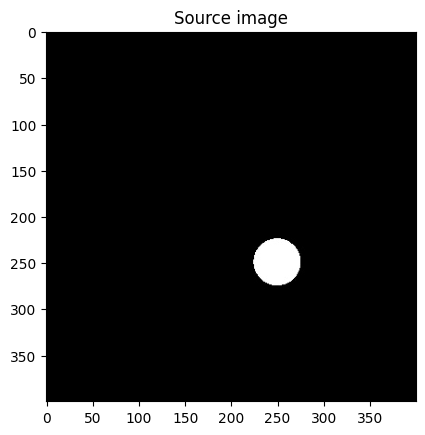

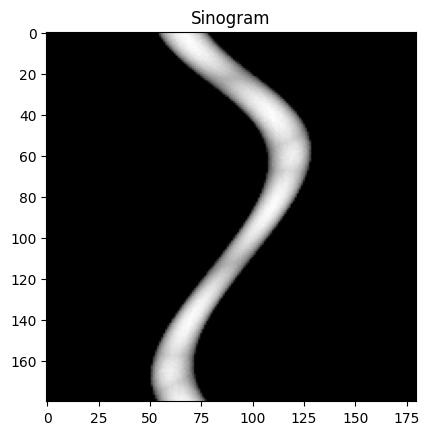

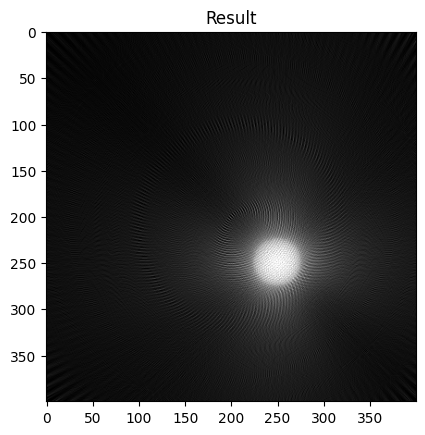

In [20]:


image = loadImage(imageName)
showImage(image, title='Source image')

radonImage = radonTransform(image, detectors, scans, detectingAngle)
showImage(radonImage, title='Sinogram')

invRadonTransform = inverseRadonTransform(radonImage, image.shape, detectingAngle)
invRadonTransform = normalizePostTransform(invRadonTransform)

showImage(invRadonTransform, title="Result")

In [21]:
def showPartialImage(n):
    showImage(invRadonSteps[n-1])

interact(showPartialImage, n=IntSlider(min=1,max=len(invRadonSteps),step=1,value=10))

interactive(children=(IntSlider(value=10, description='n', max=180, min=1), Output()), _dom_classes=('widget-i…

<function __main__.showPartialImage(n)>